# In this notebook, the location data is read from the Redis database and visualised

### **Retrieve and Transform Location Data from Redis**

This step retrieves location data from Redis, decodes and processes it into a structured format, and converts it into a Pandas DataFrame for further analysis.

In [1]:
from redis import Redis
import folium
import json
import pandas as pd

redis_client = Redis(host='localhost', port=6379, db=0)

keys = [key.decode('utf-8') for key in redis_client.keys("location:*")]

locations = []

for key in keys:
    start_time, end_time = key.split("location:")[1].split("_")

    data = redis_client.hgetall(key)

    decoded_data = {k.decode('utf-8'): float(v.decode('utf-8')) for k, v in data.items() if k in [b"latitude", b"longitude"]}
    decoded_data.update({'start_time': start_time, 'end_time': end_time})

    locations.append(decoded_data)

location_df = pd.DataFrame(locations)

location_df

,latitude,longitude,start_time,end_time
0,46.654775,7.872708,2025-01-22 18:48:30,2025-01-22 18:49:00
1,46.655227,7.873545,2025-01-22 18:45:00,2025-01-22 18:45:30
2,46.654560,7.873859,2025-01-22 18:44:00,2025-01-22 18:44:30
3,46.654232,7.873971,2025-01-22 18:43:30,2025-01-22 18:44:00
4,46.655115,7.872303,2025-01-22 18:48:00,2025-01-22 18:48:30
5,46.654085,7.872924,2025-01-22 18:50:00,2025-01-22 18:50:30
6,46.654003,7.873838,2025-01-22 18:43:00,2025-01-22 18:43:30
7,46.654404,7.872525,2025-01-22 18:49:00,2025-01-22 18:49:30
8,46.655505,7.873513,2025-01-22 18:45:30,2025-01-22 18:46:00
9,46.654105,7.872894,2025-01-22 18:49:30,2025-01-22 18:50:00


### **Retrieve and Transform Barometer Data from Redis**

This step retrieves barometer data stored in Redis, decodes and processes it into a structured format, and converts it into a Pandas DataFrame for analysis.

In [2]:
redis_client = Redis(host='localhost', port=6379, db=0)

keys = [key.decode('utf-8') for key in redis_client.keys("barometer:*")]

barometers = []

for key in keys:
    start_time, end_time = key.split("barometer:")[1].split("_")

    data = redis_client.hgetall(key)

    decoded_data = {k.decode('utf-8'): float(v.decode('utf-8')) for k, v in data.items() if k in [b"altitude_change"]}
    decoded_data.update({'start_time': start_time, 'end_time': end_time})

    barometers.append(decoded_data)

barometer_df = pd.DataFrame(barometers)

barometer_df

,altitude_change,start_time,end_time
0,1.938965,2025-01-22 18:45:00,2025-01-22 18:45:30
1,1.782715,2025-01-22 18:43:00,2025-01-22 18:43:30
2,2.771973,2025-01-22 18:49:30,2025-01-22 18:50:00
3,1.942383,2025-01-22 18:43:30,2025-01-22 18:44:00
4,1.215820,2025-01-22 18:47:30,2025-01-22 18:48:00
5,1.237305,2025-01-22 18:48:30,2025-01-22 18:49:00
6,0.754883,2025-01-22 18:44:30,2025-01-22 18:45:00
7,-0.000000,2025-01-22 18:50:00,2025-01-22 18:50:30
8,1.510742,2025-01-22 18:44:00,2025-01-22 18:44:30
9,1.202148,2025-01-22 18:48:00,2025-01-22 18:48:30


### **Visualize Altitude Changes Over Time**

This step visualizes the altitude changes from the `barometer_df` data:
- **Sorting**: The DataFrame is sorted by `start_time` to ensure the plot follows a chronological order.
- **Plotting**:
  - X-Axis: `start_time` (time of measurement).
  - Y-Axis: `altitude_change` (calculated altitude change in meters).
  - A line plot with markers for better clarity.
- **Title and Labels**: Clearly labels the axes and provides a descriptive title.
- **Grid**: Adds a grid to improve readability of the plot.

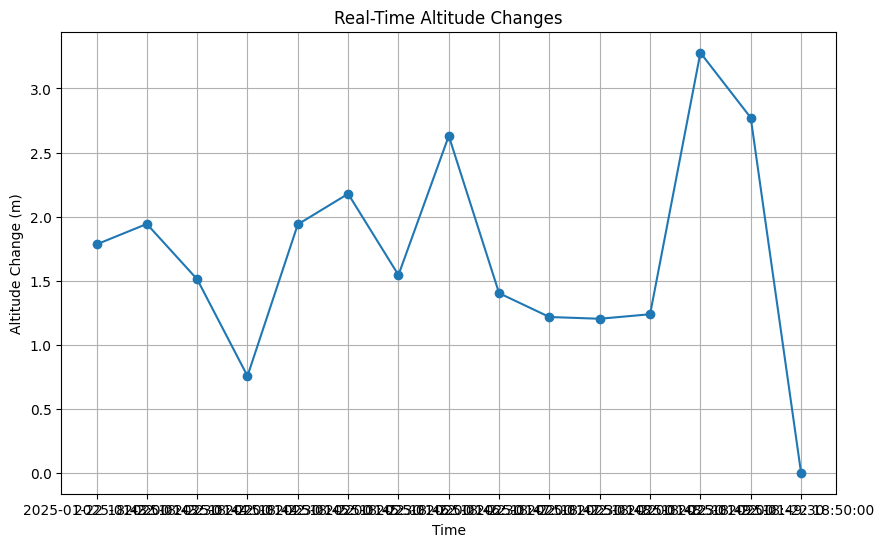

In [3]:
import matplotlib.pyplot as plt

barometer_df = barometer_df.sort_values(by='start_time')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(barometer_df['start_time'], barometer_df['altitude_change'], marker='o')
plt.xlabel('Time')
plt.ylabel('Altitude Change (m)')
plt.title('Real-Time Altitude Changes')
plt.grid()
plt.show()

### **Merge Location and Barometer Data**

This step prepares the `location_df` and `barometer_df` DataFrames by converting `start_time` and `end_time` columns to datetime format and then merges them on these columns using an inner join to create a unified `merged_df` for analysis.

In [4]:
location_df['start_time'] = pd.to_datetime(location_df['start_time'])
location_df['end_time'] = pd.to_datetime(location_df['end_time'])

barometer_df['start_time'] = pd.to_datetime(barometer_df['start_time'])
barometer_df['end_time'] = pd.to_datetime(barometer_df['end_time'])

merged_df = pd.merge(location_df, barometer_df, on=['start_time', 'end_time'], how='inner')
merged_df = merged_df.sort_values(by='start_time')

merged_df

,latitude,longitude,start_time,end_time,altitude_change
6,46.654003,7.873838,2025-01-22 18:43:00,2025-01-22 18:43:30,1.782715
3,46.654232,7.873971,2025-01-22 18:43:30,2025-01-22 18:44:00,1.942383
2,46.654560,7.873859,2025-01-22 18:44:00,2025-01-22 18:44:30,1.510742
10,46.654929,7.873665,2025-01-22 18:44:30,2025-01-22 18:45:00,0.754883
1,46.655227,7.873545,2025-01-22 18:45:00,2025-01-22 18:45:30,1.938965
8,46.655505,7.873513,2025-01-22 18:45:30,2025-01-22 18:46:00,2.177734
12,46.655713,7.873077,2025-01-22 18:46:00,2025-01-22 18:46:30,1.543457
14,46.655622,7.872560,2025-01-22 18:46:30,2025-01-22 18:47:00,2.629883
13,46.655668,7.871995,2025-01-22 18:47:00,2025-01-22 18:47:30,1.401855
11,46.655410,7.871961,2025-01-22 18:47:30,2025-01-22 18:48:00,1.215820


### **Visualize Merged Data on a Map**

This step visualizes the merged location and barometer data using Folium:
- **Map Initialization**: Centers the map at the average latitude and longitude of the merged data.
- **Markers**: Adds markers at each location, displaying the `altitude_change` as a popup.
- **Polyline**: Draws a purple line connecting the locations to represent the movement path.
- **Save Map**: Saves the map as `map.html` for easy viewing and sharing.

In [5]:
m = folium.Map(location=[merged_df["latitude"].mean(), merged_df["longitude"].mean()], zoom_start=17)

locations = list(zip(merged_df['latitude'], merged_df['longitude']))

for _, row in merged_df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=f"Altitude Change: {row['altitude_change']}").add_to(m)

folium.PolyLine(locations, color="purple", weight=2.5, opacity=1).add_to(m)

m.save("map.html")
m